In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats
import statsmodels.api as sm
from itertools import product
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

In [2]:
LTC_Data = pd.read_csv("../data/LTC_1d_price.csv")

In [3]:
LTC_Data.set_index("open_time", inplace=True, drop=True)

In [4]:
LTC_Data.index = pd.to_datetime(LTC_Data.index)

In [5]:
LTC_Data.rename(columns={"close": "Close"}, inplace=True)

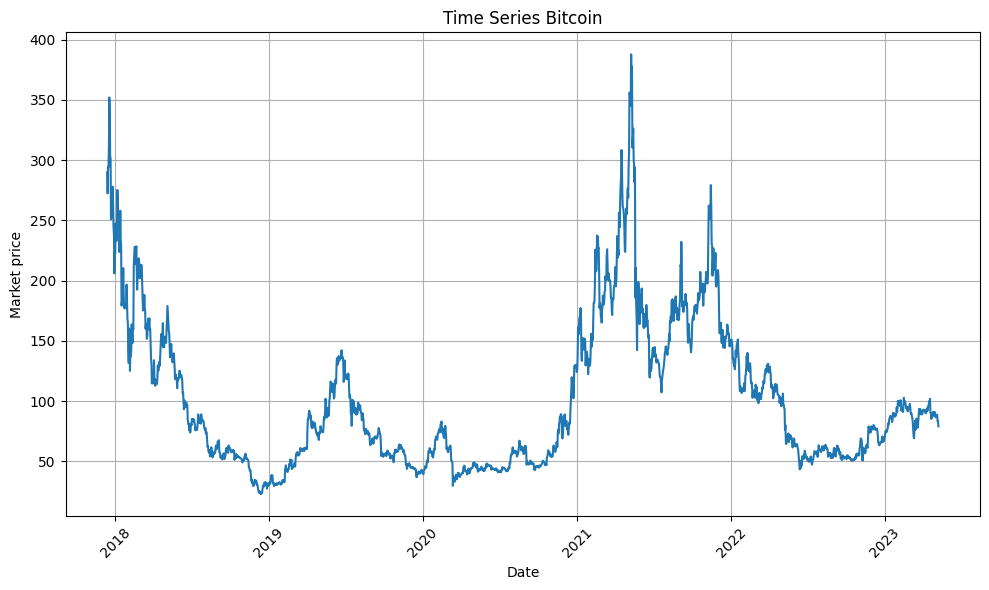

In [6]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(LTC_Data.index, LTC_Data['Close'], linestyle='-')  # Create the line plot
plt.title('Time Series Bitcoin')  # Set the title
plt.xlabel('Date')  # Set the x-axis label
plt.ylabel('Market price')  # Set the y-axis label
plt.grid(True)  # Show grid lines
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Show the plot
plt.show()

### Preliminary Analysis of the Bitcoin time-series

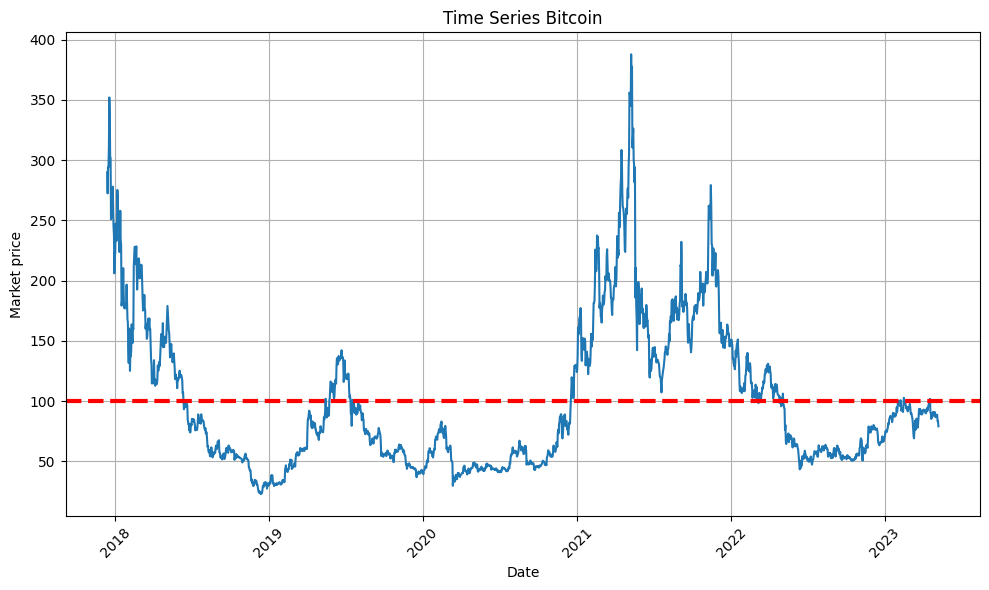

In [7]:
# create a time series plot with a mean line
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(LTC_Data.index, LTC_Data['Close'], linestyle='-')  # Create the line plot
plt.axhline(y=np.nanmean(LTC_Data['Close']), color='red', linestyle='--', linewidth=3, label='Avg')
plt.title('Time Series Bitcoin')  # Set the title
plt.xlabel('Date')  # Set the x-axis label
plt.ylabel('Market price')  # Set the y-axis label
plt.grid(True)  # Show grid lines
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Show the plot
plt.show()

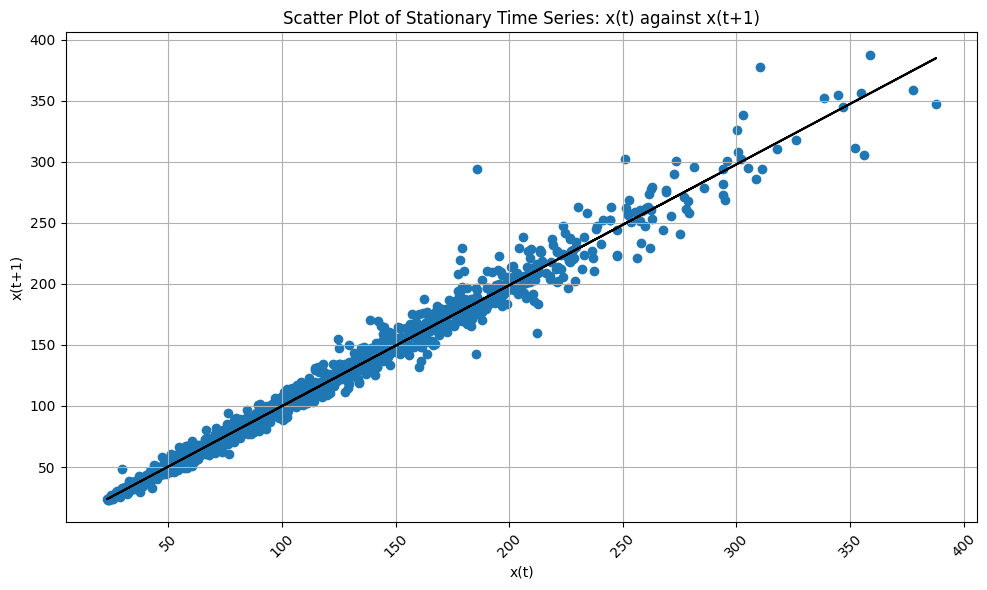

In [8]:
# make regression line between x(t) and x(t+1)
lr = LinearRegression()
lr.fit(np.array(LTC_Data['Close'][:-1]).reshape(-1,1), LTC_Data['Close'][1:])
y_pred = lr.predict(np.array(LTC_Data['Close'][:-1]).reshape(-1,1))

# scatter plot between x(t) and x(t+1)
plt.figure(figsize=(10, 6))  # Set the figure size
plt.scatter(LTC_Data['Close'][1:], LTC_Data['Close'][:-1])  # Create the scatter plot
plt.plot(LTC_Data['Close'][:-1], y_pred, color='k') #LinearRegression plot
plt.title('Scatter Plot of Stationary Time Series: x(t) against x(t+1)')  # Set the title
plt.xlabel('x(t)')  # Set the x-axis label
plt.ylabel('x(t+1)')  # Set the y-axis label
plt.grid(True)  # Show grid lines
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels 

# Show the plot
plt.show()

### shows positive correlation

#### Addressing the Seasonality, Trends of TS

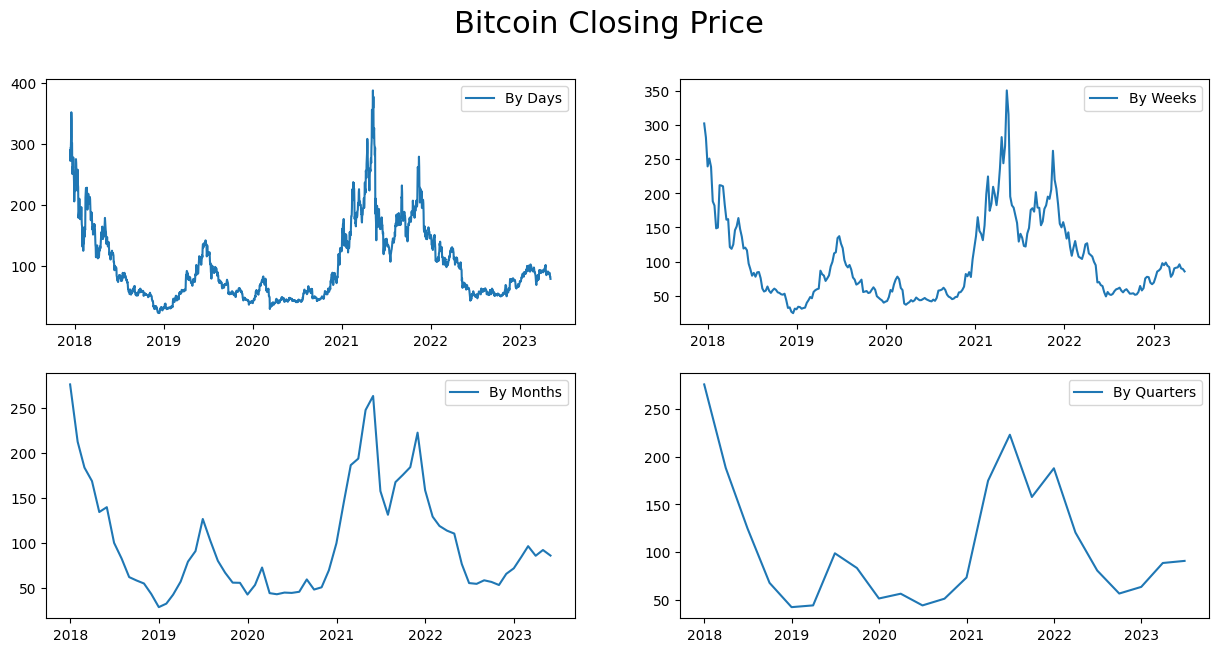

In [9]:
df = LTC_Data[["Close"]]
# resampling to daily, monthly, annual and quarterly frequency
df = df.resample('D').mean()
df_month = df.resample('M').mean()
df_year = df.resample('A-DEC').mean()
df_Q = df.resample('Q-DEC').mean()
df_week = df.resample('W-MON').mean()

# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin Closing Price', fontsize=22)

plt.subplot(221)
plt.plot(df.Close, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_week.Close, '-', label='By Weeks')
plt.legend()

plt.subplot(223)
plt.plot(df_month.Close, '-', label='By Months')
plt.legend()

plt.subplot(224)
plt.plot(df_Q.Close, '-', label='By Quarters')
plt.legend()

# plt.subplot(224)
# plt.plot(df_year.Close, '-', label='By Years')
# plt.legend()

# plt.tight_layout()
plt.show()

#### Stationarity check and STL-decomposition of the series

Is the model an additive or multiplicative model? How to interpret this?

Dickey–Fuller test: p=0.077765


<Figure size 1500x700 with 0 Axes>

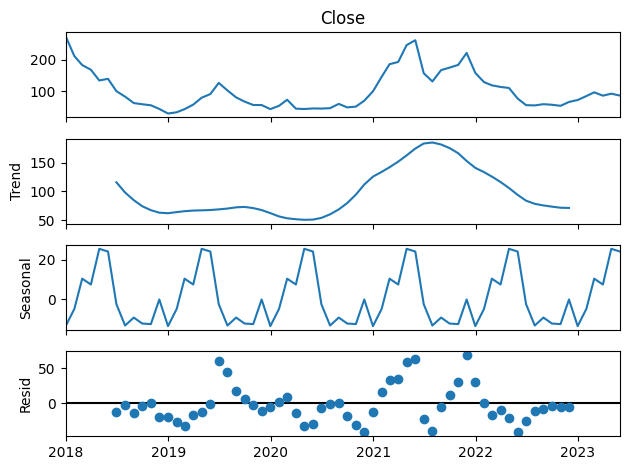

In [10]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Close, model="additive").plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Close)[1])
plt.show()

Taking into account the trends and seasonal behaviour, the series does not look stationary as the values depend upon the timeframe. In terms of residuals, this also does not looks stationary (looks like it has a pattern and is not random in my opinion). Thus, overall, this is a non stationary timeseries.

Dickey–Fuller test: p=0.077765


<Figure size 1500x700 with 0 Axes>

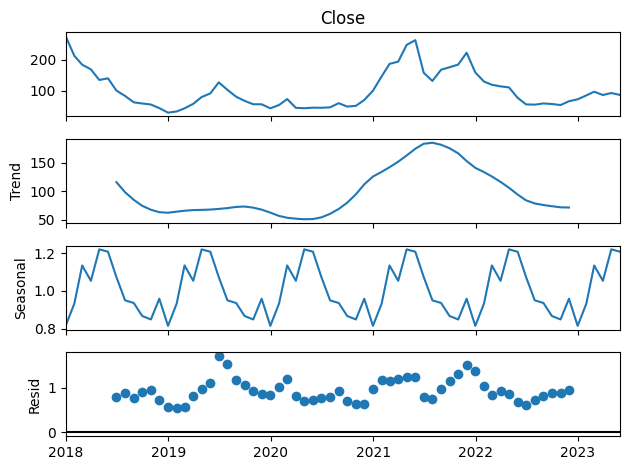

In [11]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Close, model="multiplicative").plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Close)[1])
plt.show()

For the multiplicative model, the residuals look random, thus, (in my opinion), it can be considered stationary

Overall: The presence of trend and seasonal component in the Time Series makes it non-stationary and thus, differencing would be required to make it stationary. The presence of seasonality also means we can use the Seasonality based models (eg. SARIMA).

Dickey–Fuller test: p=0.211069


<Figure size 1500x700 with 0 Axes>

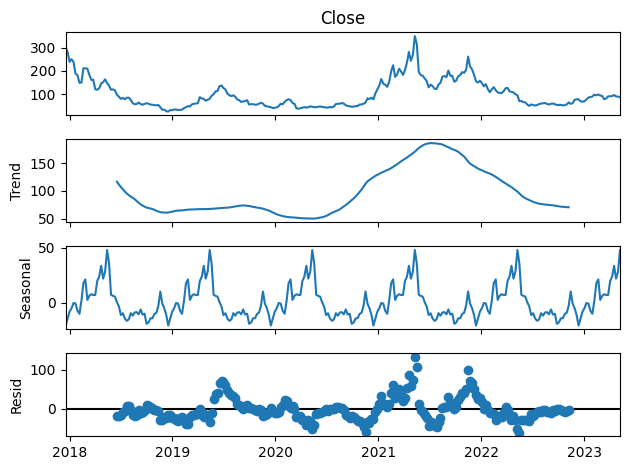

In [12]:
# predicting by weeks
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_week.Close, model="additive").plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_week.Close)[1])
plt.show()

We notice yearly seasonality here.

Dickey–Fuller test: p=0.211069


<Figure size 1500x700 with 0 Axes>

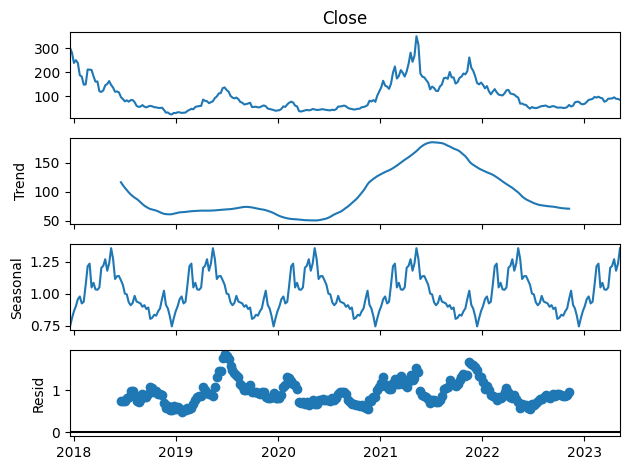

In [13]:
# predicting by weeks
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_week.Close, model="multiplicative").plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_week.Close)[1])
plt.show()

#### Transformations

p-value needs to be as little as possible, preferably alpha<0.05, for stationarity

On a time series plot, the analyst sees that the difference between the high and low seasonal peaks grows over time. This pattern indicates that the variance is not stationary. The analyst performs a Box-Cox transformation to make the variance stationary before the analyst fits the ARIMA model. - in the current case, variance increases and decreases- is box transformation really necessary?

In [14]:
# Box-Cox Transformations
df_week['Close_box'], lmbda = stats.boxcox(df_week.Close)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_week.Close)[1])
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_week.Close_box)[1])

Dickey–Fuller test: p=0.211069
Dickey–Fuller test: p=0.122939


Dickey–Fuller test: p=0.000000


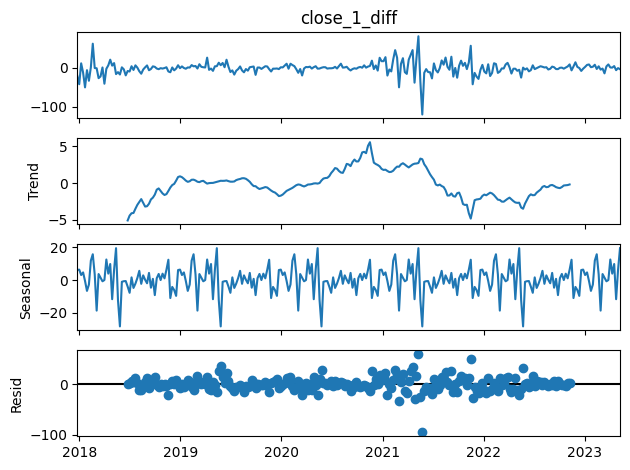

In [15]:
# Single differentiation wo box transformation - can be used for a simple ARIMA model.
df_week['close_1_diff'] = df_week.Close - df_week.Close.shift(1)
sm.tsa.seasonal_decompose(df_week.close_1_diff[1:], model="additive").plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_week.close_1_diff[1:])[1])
# the variance seems to be increasing here

Dickey–Fuller test: p=0.000000


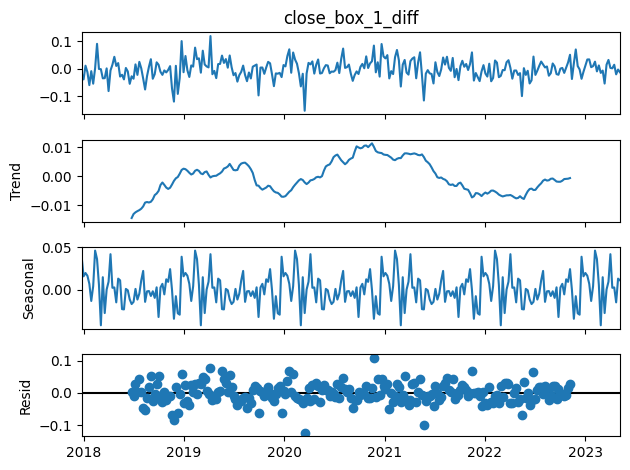

In [16]:
# Single differentiation - can be used for ARIMA model with box transformation.
df_week['close_box_1_diff'] = df_week.Close_box - df_week.Close_box.shift(1)
sm.tsa.seasonal_decompose(df_week.close_box_1_diff[1:], model="additive").plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_week.close_box_1_diff[1:])[1])
# no increasing variance here

Dickey–Fuller test: p=0.015819


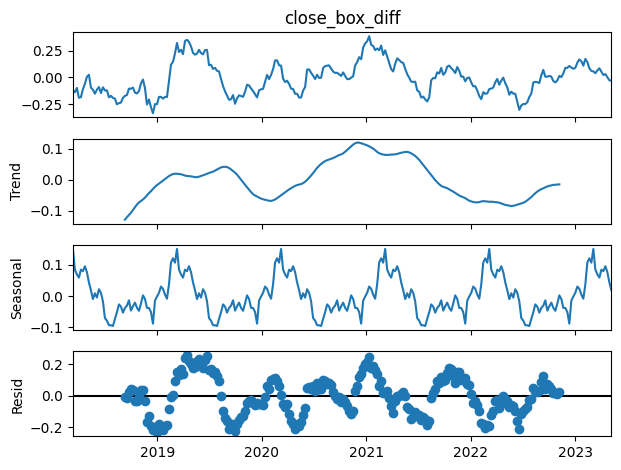

In [17]:
# Seasonal differentiation - can be used for SARIMA Model
df_week['close_box_diff'] = df_week.Close_box - df_week.Close_box.shift(12)
sm.tsa.seasonal_decompose(df_week.close_box_diff[12:], model="additive").plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_week.close_box_diff[12:])[1])

This is stationary

#### Computing the ACF and PACF - for the stationary time series

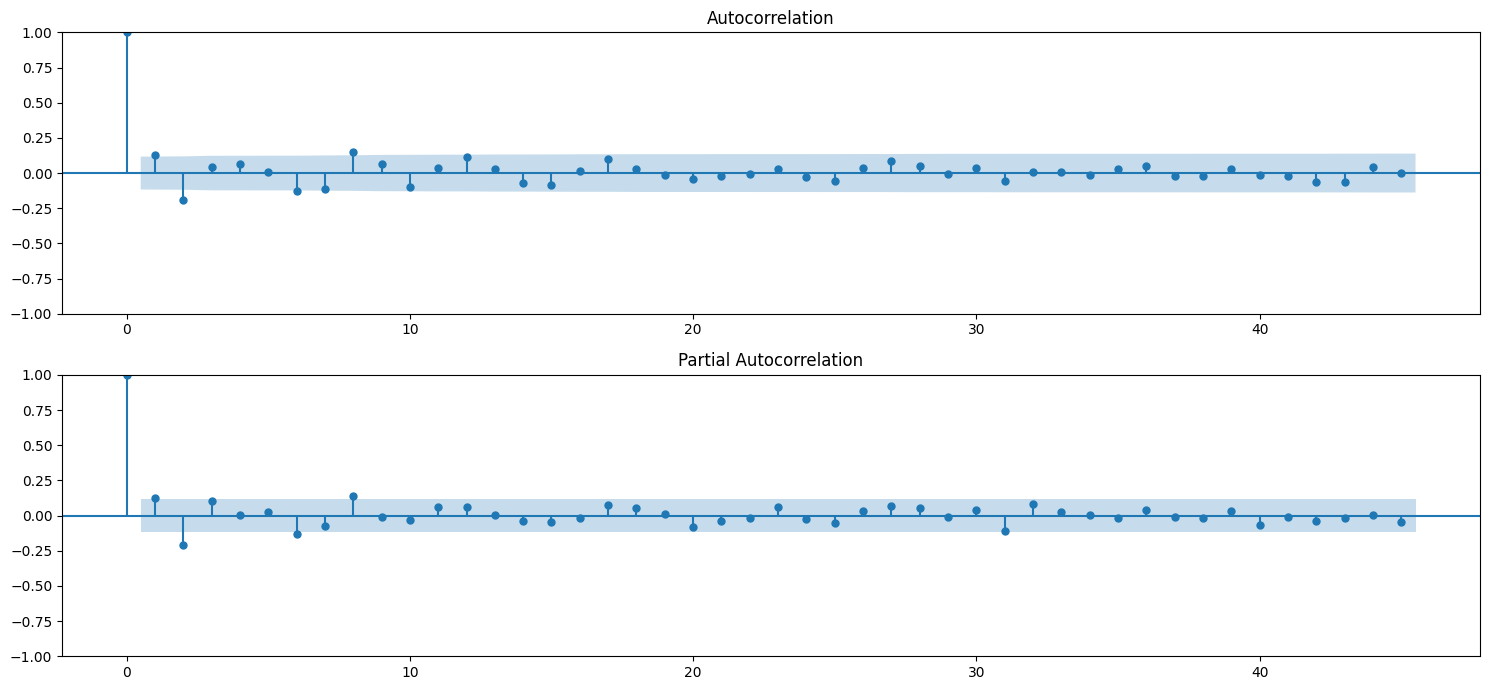

In [18]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_week.close_1_diff[1:].values.squeeze(), lags=45, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_week.close_1_diff[1:].values.squeeze(), lags=45, ax=ax)
plt.tight_layout()
plt.show()

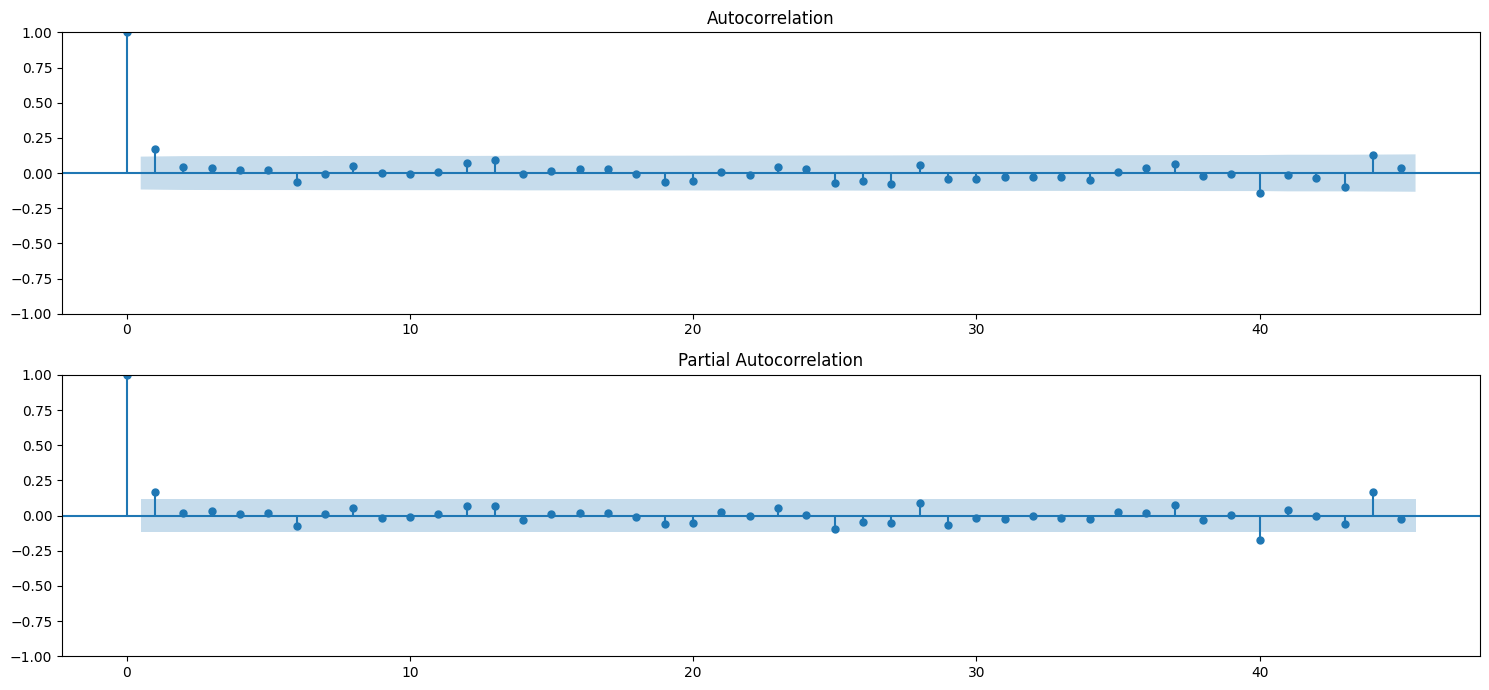

In [19]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots - best and simplest model?
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_week.close_box_1_diff[1:].values.squeeze(), lags=45, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_week.close_box_1_diff[1:].values.squeeze(), lags=45, ax=ax)
plt.tight_layout()
plt.show()

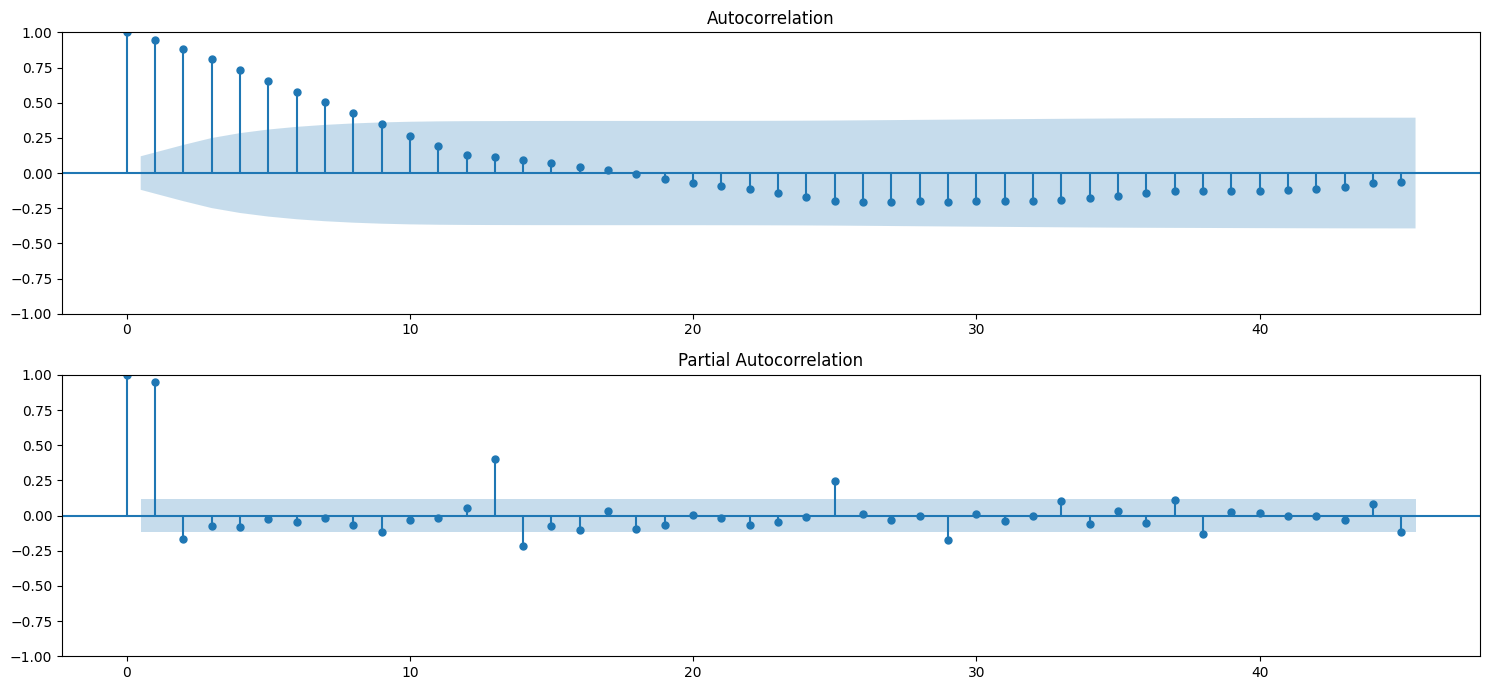

In [20]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_week.close_box_diff[12:].values.squeeze(), lags=45, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_week.close_box_diff[12:].values.squeeze(), lags=45, ax=ax)
plt.tight_layout()
plt.show()

In [21]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(df_week.close_box_1_diff[1:], lags=10)

,lb_stat,lb_pvalue
1,8.273664,0.004022
2,8.841678,0.012024
3,9.261032,0.026014
4,9.431791,0.051168
5,9.612047,0.087004
6,10.721071,0.097389
7,10.744916,0.150139
8,11.565705,0.171658
9,11.566130,0.238888
10,11.587023,0.313646


#### Modelling the series

In [22]:
# using the ARIMA Model on Untransformed Shift 1 data
ps = (0,1,2,3,4)
qs = (0,1,2,3,4)
d = 1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

results = []
best_aic = float("inf")
for param in parameters_list:
    try:
        arima_model=ARIMA(df_week.Close, order=(param[0], d, param[1]))
        model = arima_model.fit()
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model_1 = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model_1.summary())

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: N

   parameters          aic
14     (2, 4)  2339.702848
18     (3, 3)  2340.222485
13     (2, 3)  2340.812148
19     (3, 4)  2341.204703
24     (4, 4)  2343.363602
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  282
Model:                 ARIMA(2, 1, 4)   Log Likelihood               -1162.851
Date:                Tue, 10 Oct 2023   AIC                           2339.703
Time:                        16:39:15   BIC                           2365.171
Sample:                    12-18-2017   HQIC                          2349.917
                         - 05-08-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3965      0.035     11.190     

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Dickey–Fuller test:: p=0.000000


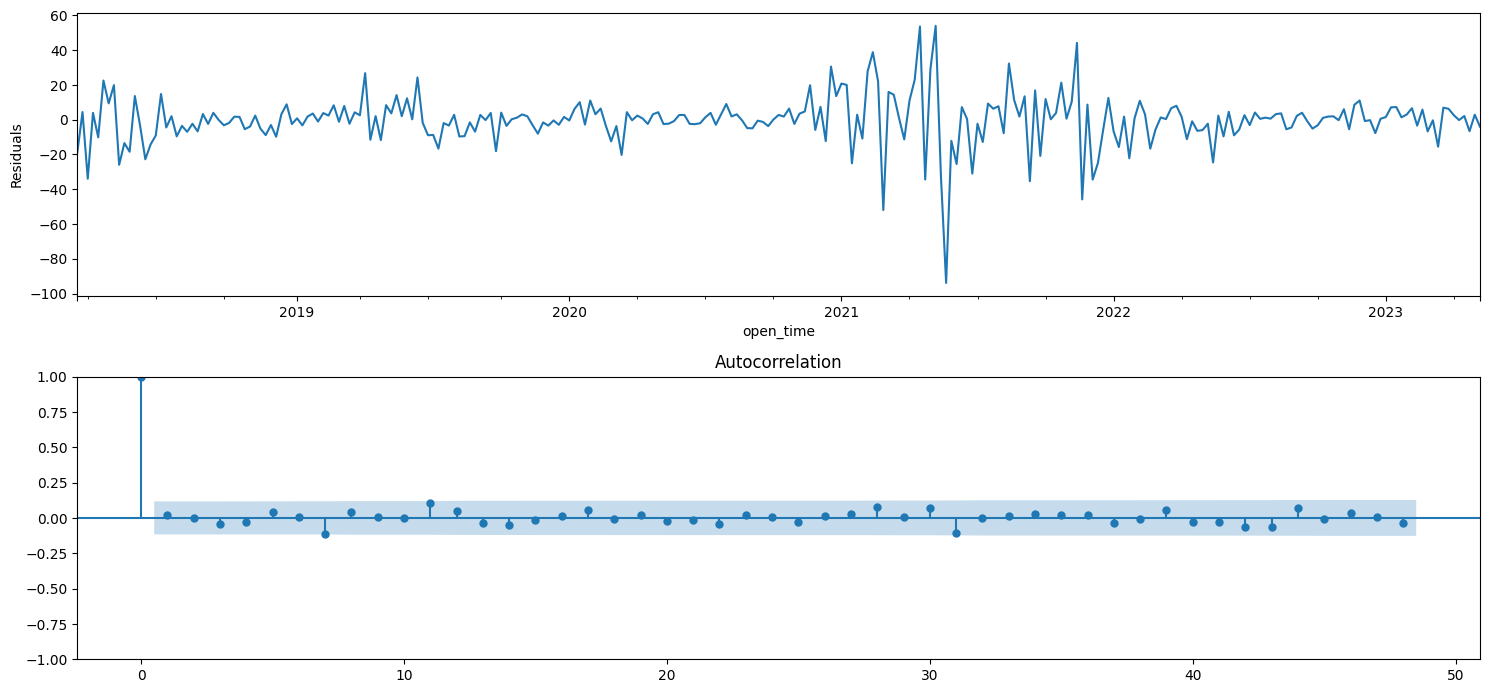

In [23]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model_1.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model_1.resid[1:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model_1.resid[1:])[1])

plt.tight_layout()
plt.show()

In [24]:
# using the ARIMA Model on Box-transformed Shift 1 data
ps = (0,1,2)
qs = (0,1,2)
d = 1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

results = []
best_aic = float("inf")
for param in parameters_list:
    try:
        arima_model=ARIMA(df_week.Close_box, order=(param[0], d, param[1]))
        model = arima_model.fit()
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model_2 = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model_2.summary())

  parameters          aic
3     (1, 0) -1086.960501
1     (0, 1) -1086.536009
4     (1, 1) -1085.077475
6     (2, 0) -1085.040069
2     (0, 2) -1084.886629
                               SARIMAX Results                                
Dep. Variable:              Close_box   No. Observations:                  282
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 545.480
Date:                Tue, 10 Oct 2023   AIC                          -1086.961
Time:                        16:39:15   BIC                          -1079.684
Sample:                    12-18-2017   HQIC                         -1084.042
                         - 05-08-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1716      0.068      2.506      0.012

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Dickey–Fuller test:: p=0.000000


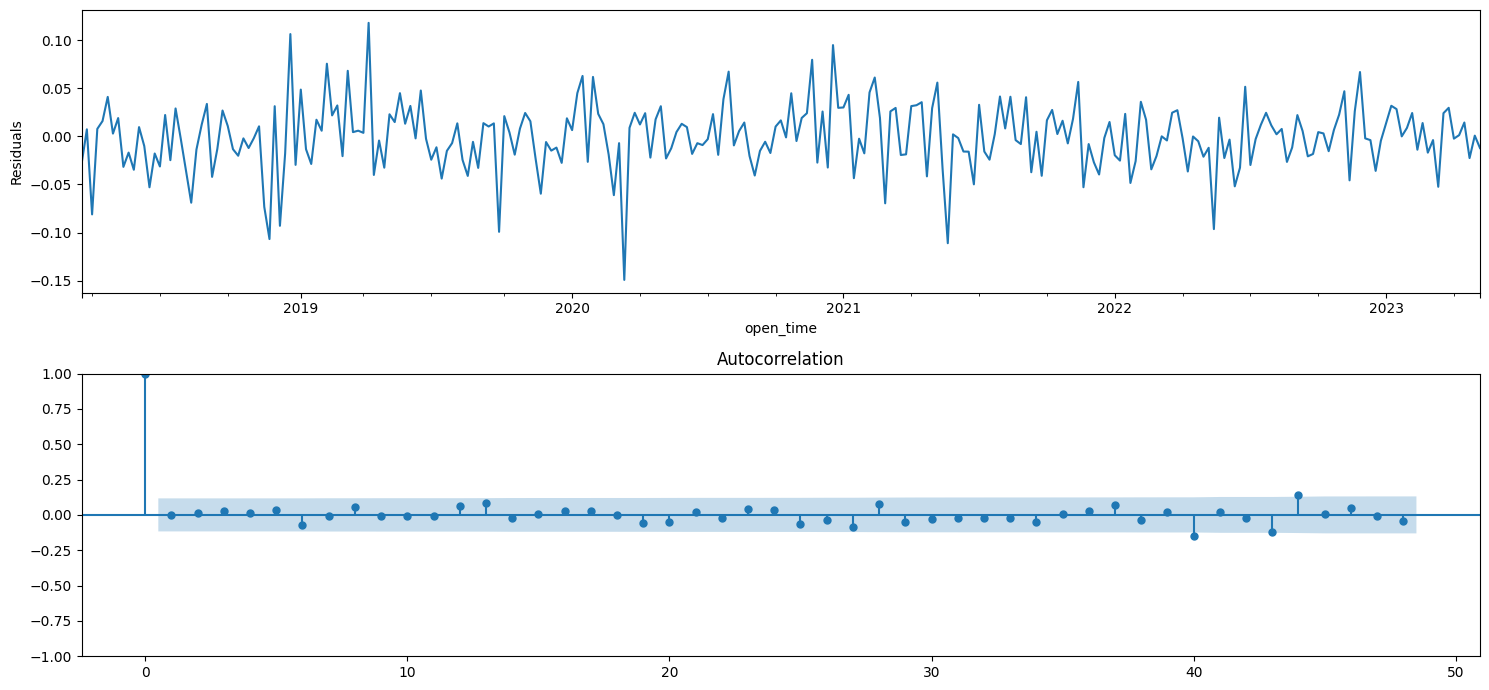

In [25]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model_2.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model_2.resid[1:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model_2.resid[13:])[1])

plt.tight_layout()
plt.show()

In [26]:
# using the ARIMA Model on Box-transformed Seasonal Shift
ps = range(0,3)
qs = range(0,3)
d = 1
D = 1
Ps = range(0,3)
Qs = range(0,3)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

results = []
best_aic = float("inf")
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_week.Close_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model_3 = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model_3.summary())

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximu

      parameters         aic
28  (1, 0, 0, 1) -998.583087
10  (0, 1, 0, 1) -998.053747
31  (1, 0, 1, 1) -997.933731
29  (1, 0, 0, 2) -997.821658
13  (0, 1, 1, 1) -997.419617
                                      SARIMAX Results                                       
Dep. Variable:                            Close_box   No. Observations:                  282
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 502.292
Date:                              Tue, 10 Oct 2023   AIC                           -998.583
Time:                                      16:43:31   BIC                           -987.799
Sample:                                  12-18-2017   HQIC                          -994.252
                                       - 05-08-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

Dickey–Fuller test:: p=0.000000


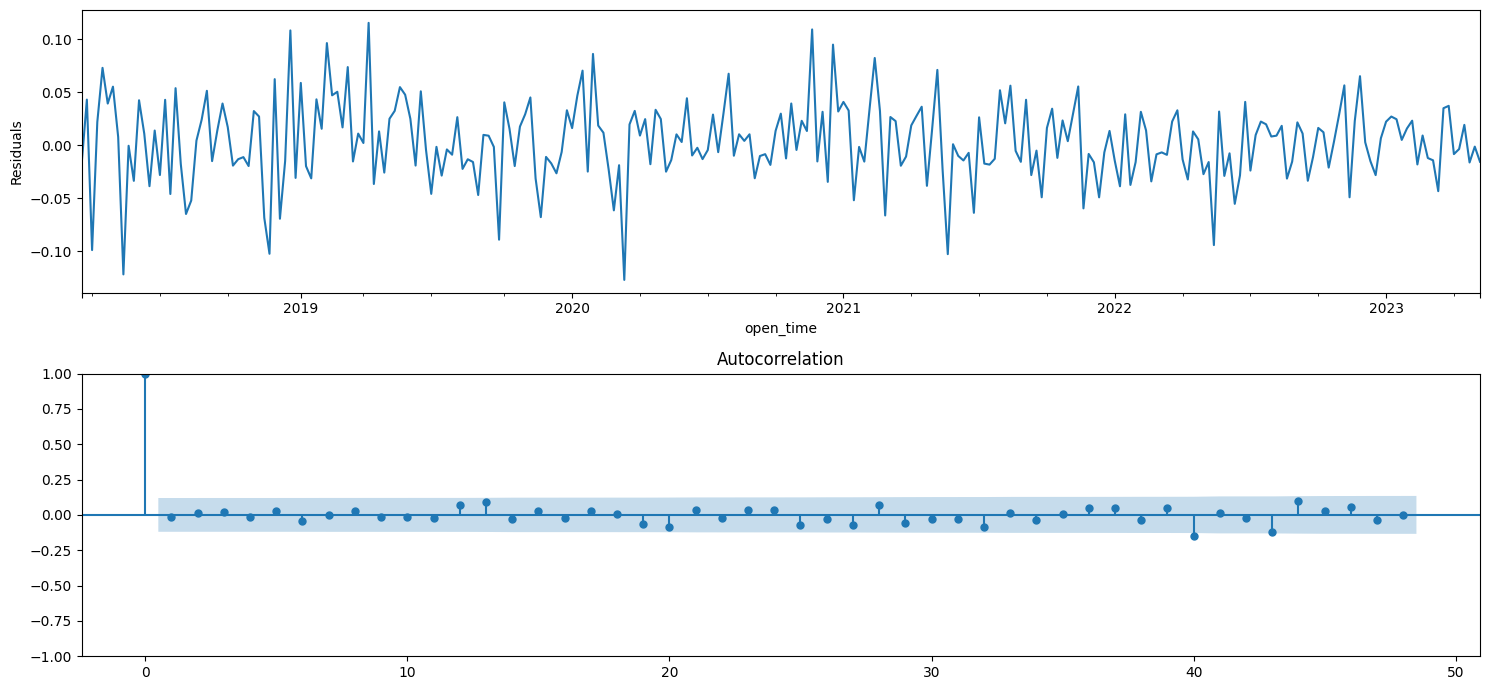

In [27]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model_3.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model_3.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model_3.resid[13:])[1])

plt.tight_layout()
plt.show()

#### Model Forecasting

In [28]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

/var/folders/2y/x00pyx115dl4rz225kttc1pw0000gn/T/ipykernel_32598/1192123877.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week2['forecast'] = best_model_1.predict(start=0, end=df_week2.shape[0])


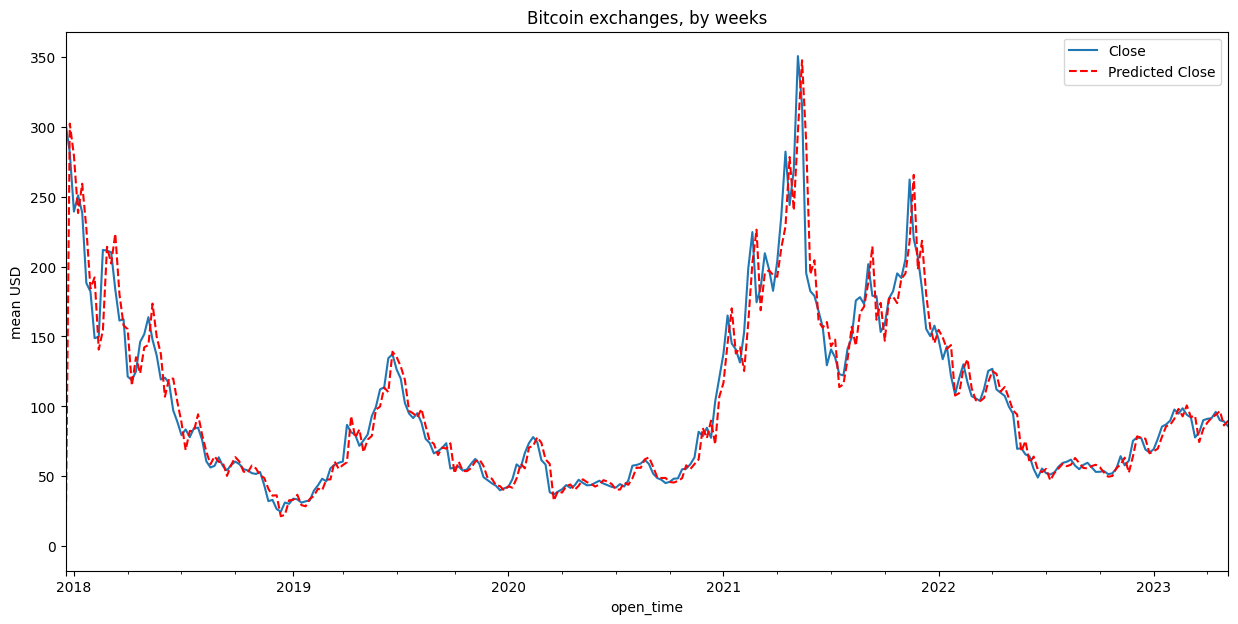

Root Mean Squared Error = 23.557990203569442
R2 Score = 0.8511294414670041


In [29]:
# Prediction - best_model 1
df_week2 = df_week[['Close']]
df_week2['forecast'] = best_model_1.predict(start=0, end=df_week2.shape[0])
plt.figure(figsize=(15,7))
df_week2.Close.plot()
df_week2.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Bitcoin exchanges, by weeks')
plt.ylabel('mean USD')
plt.show()
print(f"Root Mean Squared Error = {sqrt(mean_squared_error(df_week2.Close, df_week2.forecast))}")
print(f"R2 Score = {r2_score(df_week2.Close, df_week2.forecast)}")

/var/folders/2y/x00pyx115dl4rz225kttc1pw0000gn/T/ipykernel_32598/1037079834.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week3['forecast'] = invboxcox(best_model_2.predict(start=0, end=df_week3.shape[0]), lmbda)


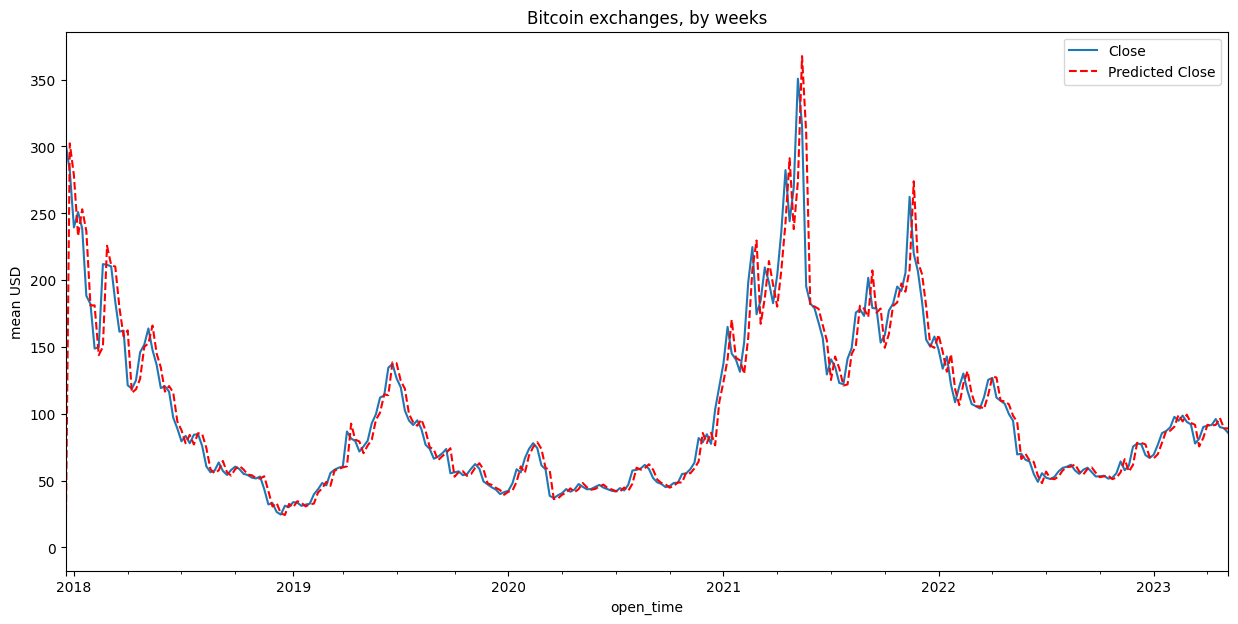

Root Mean Squared Error = 24.130739283912558
R2 Score = 0.8438026725079565


In [32]:
# Prediction - best_model 2
df_week3 = df_week[['Close']]
df_week3['forecast'] = invboxcox(best_model_2.predict(start=0, end=df_week3.shape[0]), lmbda)
plt.figure(figsize=(15,7))
df_week3.Close.plot()
df_week3.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Bitcoin exchanges, by weeks')
plt.ylabel('mean USD')
plt.show()
print(f"Root Mean Squared Error = {sqrt(mean_squared_error(df_week3.Close, df_week3.forecast))}")
print(f"R2 Score = {r2_score(df_week3.Close, df_week3.forecast)}")

/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2y/x00pyx115dl4rz225kttc1pw0000gn/T/ipykernel_32598/4026734324.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week4['forecast'] = invboxcox(best_model_3.predict(start=0, end=df_week4.shape[0]), lmbda)


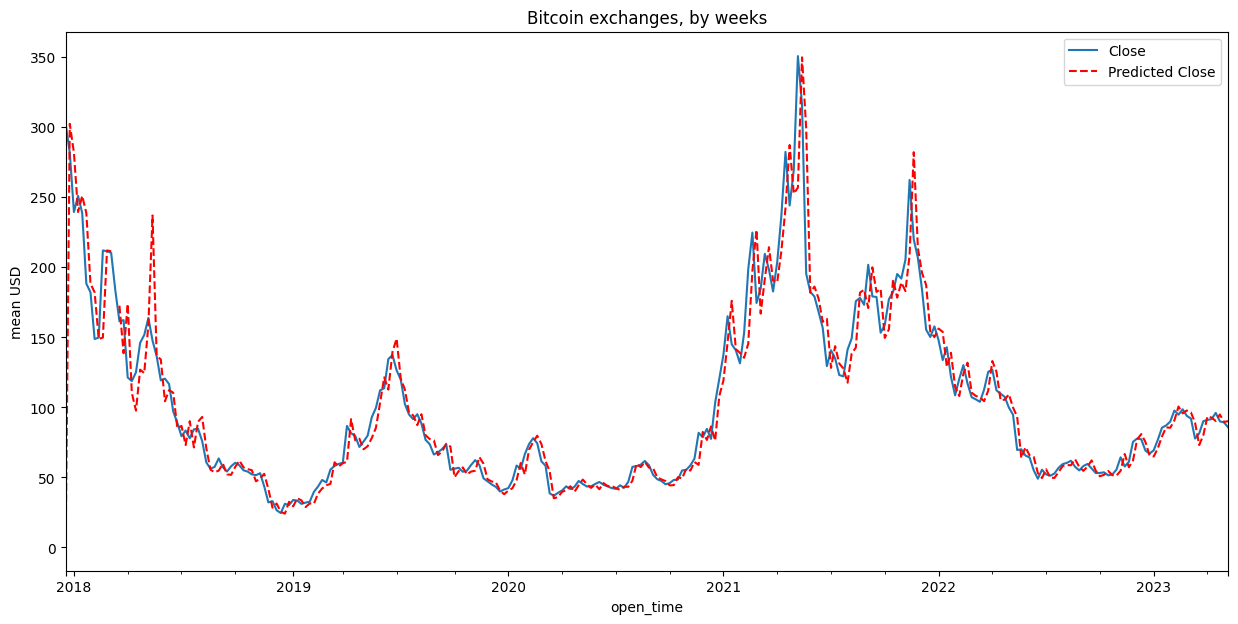

ValueError: Input contains NaN.

In [33]:
# Prediction - best_model 3
df_week4 = df_week[['Close']]
df_week4['forecast'] = invboxcox(best_model_3.predict(start=0, end=df_week4.shape[0]), lmbda)
plt.figure(figsize=(15,7))
df_week4.Close.plot()
df_week4.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Bitcoin exchanges, by weeks')
plt.ylabel('mean USD')
plt.show()
print(f"Root Mean Squared Error = {sqrt(mean_squared_error(df_week4.Close, df_week4.forecast))}")
print(f"R2 Score = {r2_score(df_week4.Close, df_week4.forecast)}")